# Import Libraries

In [1]:
# for creating neural network architecture
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

# for image processing
import cv2
import numpy as np

# for dataset management
import os, shutil

# for time management
from tqdm import tqdm

# Setting up hardware

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if physical_devices != []:
    print("Using GPU")
    for i in physical_devices:
        tf.config.experimental.set_memory_growth(i, True)
else:
    print("Using CPU")
    pass

Using GPU


# Load Dataset

In [3]:
root_dir = str(input("Path where 'classify train' directory belongs: "))
classify_train = os.path.join(root_dir, 'classify train')

train_directory = os.path.join(classify_train, 'training')
validation_directory = os.path.join(classify_train, 'validation')
test_directory = os.path.join(classify_train, 'testing')

Path where 'classify train' directory belongs: /mnt/335fff25-d210-4fe2-8249-4ba8b4a17ce4/DATASETS/Shrabana/cov-cxr


# Callbacks

In [4]:
learning_rate = 0.001
steps = 1 # change steps to 1 to apply exponential decay

def lr_schedule(epoch):
    return learning_rate * (0.1 ** int(epoch / steps))


callback = [tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose = 1),
            tf.keras.callbacks.EarlyStopping(monitor = 'loss', min_delta = 0.001, patience = 10, verbose = 1, mode = "min")]

# Generator

In [5]:
class_no = len(os.listdir(train_directory))

print("This is a " + str(class_no) + "-Class Classification")

if class_no <= 2:
    class_mode = 'binary'
    output_activation = 'sigmoid'
    output_neurons = 1
    losses = 'binary_crossentropy'

else:
    class_mode = 'categorical'
    output_activation = 'softmax'
    output_neurons = class_no
    losses = 'categorical_crossentropy'

This is a 3-Class Classification


In [6]:
h = int(input("Image Dimension(H or W): "))
w = h
target_size = (h,w)
color = int(input("Press 1 for RGB \nPress 2 for Grayscale "))
if color == 1:
    color_mode = 'rgb'
    dim = (h,w,3)
elif color == 2:
    color_mode = 'grayscale'
    dim = (h,w,1)

Image Dimension(H or W): 128
Press 1 for RGB 
Press 2 for Grayscale 1


# Model Architecture

In [7]:
no_d_layers = int(input('Dense with activation + Dropout for desnse layer = 1 dense layer \nHow many of such dense layers you want to use ? '))
d_neurons = int(input('Enter no.of neurons you want to use in 1st dense layer: '))
d_dropout = int(input('Enter dropout rate for dense layer: '))/100

Dense with activation + Dropout for desnse layer = 1 dense layer 
How many of such dense layers you want to use ? 0
Enter no.of neurons you want to use in 1st dense layer: 0
Enter dropout rate for dense layer: 0


**Don't put user inputs inside the function below as it'll be called multiple times inside a loop**

In [8]:
def DenseNet121():
    print("\nTRAINING ON DenseNet121 MODEL:-")
    
    base_model = tf.keras.applications.DenseNet121(input_shape = dim, weights = 'imagenet', include_top = False)

    x = base_model.output
    
    x = GlobalAveragePooling2D()(x)
    
    m, n = 0, 0
    for d in range(no_d_layers):
        m = 2**d
        n = d_neurons//m
        x = Dense(n, kernel_regularizer=l2(lambd), bias_regularizer=l2(lambd))(x)
        x = LeakyReLU()(x)
        x = Dropout(d_dropout)(x)
        x = BatchNormalization()(x)
    
    predictions = Dense(output_neurons, activation = output_activation)(x)  

    model = Model(inputs = base_model.input, outputs=predictions)

    train_base_model = str(input("Do you want to extract features using DenseNet121?(Y/N) "))
    if train_base_model.upper() == 'Y':
        for layer in base_model.layers:
            layer.trainable = True
    elif train_base_model.upper() == 'N':
        for layer in base_model.layers:
            layer.trainable = False

    return model

# Research

In [9]:
epoch = 100

lambd_list = []
lambd_no = int(input('Using how many lambdas you want to train with ? '))
print('Enter {} lambda value/values consecutively:'.format(lambd_no))
for i in range(lambd_no): 
    lambd = float(input('Enter lambda value: '))
    lambd_list.append(lambd)

batch_list = []
batch_no = int(input("Enter how many batches you want to use: "))
print('Enter {} batch no. consecutively:'.format(batch_no))
for j in range(batch_no):
    b_size = int(input('Enter batch size: '))
    batch_list.append(b_size)

Using how many lambdas you want to train with ? 1
Enter 1 lambda value/values consecutively:
Enter lambda value: 0.00001
Enter how many batches you want to use: 1
Enter 1 batch no. consecutively:
Enter batch size: 8


Found 8591 images belonging to 3 classes.
Found 399 images belonging to 3 classes.
Found 1995 images belonging to 3 classes.

TRAINING ON DenseNet121 MODEL:-
Do you want to extract features using DenseNet121?(Y/N) y

************ for lambda = 1e-05************

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
1074/1074 [==============================] - 91s 73ms/step - loss: 0.4479 - accuracy: 0.8538 - true_positives: 3766.5526 - true_negatives: 8113.0102 - false_positives: 494.6530 - false_negatives: 537.2791 - val_loss: 0.1680 - val_accuracy: 0.9398 - val_true_positives: 375.0000 - val_true_negatives: 774.0000 - val_false_positives: 24.0000 - val_false_negatives: 24.0000
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001.
1074/1074 [==============================] - 78s 73ms/step - loss: 0.1132 - accuracy: 0.9605 - true_positives: 4148.3823 - true_negatives: 8457.0912 - false_positives: 149.9023 - false_negatives: 155.1144

1074/1074 [==============================] - 77s 71ms/step - loss: 0.0387 - accuracy: 0.9867 - true_positives: 4244.9712 - true_negatives: 8548.9609 - false_positives: 57.2437 - false_negatives: 58.1312 - val_loss: 0.0287 - val_accuracy: 0.9900 - val_true_positives: 395.0000 - val_true_negatives: 794.0000 - val_false_positives: 4.0000 - val_false_negatives: 4.0000
Epoch 19/100

Epoch 00019: LearningRateScheduler reducing learning rate to 1.000000000000001e-21.
1074/1074 [==============================] - 76s 71ms/step - loss: 0.0375 - accuracy: 0.9896 - true_positives: 4256.3256 - true_negatives: 8560.9730 - false_positives: 46.7144 - false_negatives: 47.5181 - val_loss: 0.0294 - val_accuracy: 0.9900 - val_true_positives: 395.0000 - val_true_negatives: 794.0000 - val_false_positives: 4.0000 - val_false_negatives: 4.0000
Epoch 20/100

Epoch 00020: LearningRateScheduler reducing learning rate to 1.0000000000000011e-22.
1074/1074 [==============================] - 76s 71ms/step - loss: 0.

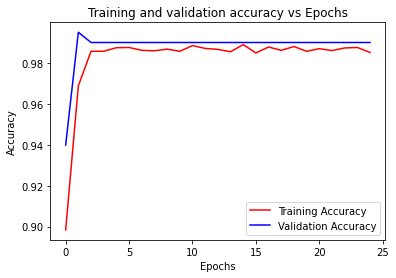

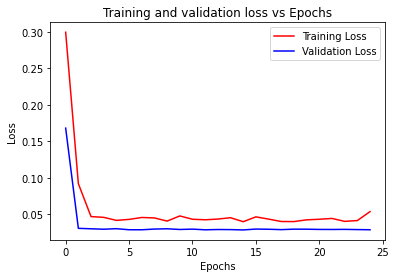

Training accuracy: 0.9932487607002258
Validation accuracy: 0.9899749159812927
Blind test accuracy: 0.9754385948181152
Sensitivity: 97.4937343358396
Specificity: 98.7719298245614


In [10]:
# iterate over batch sizes
for batch_size in batch_list: 
    train_datagen = ImageDataGenerator(rescale=1.0/255.0)
    train_generator = train_datagen.flow_from_directory(train_directory,
                                                        batch_size = batch_size,
                                                        class_mode = class_mode,
                                                        target_size = target_size)

    val_datagen = ImageDataGenerator(rescale=1.0/255.0)
    validation_generator = val_datagen.flow_from_directory(validation_directory,
                                                        batch_size = batch_size,
                                                        class_mode = class_mode,
                                                        target_size = target_size)

    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    test_generator = test_datagen.flow_from_directory(test_directory,
                                                        batch_size = batch_size,
                                                        class_mode = class_mode,
                                                        target_size = target_size)
    
    # iterate over lambdas
    for lambd in lambd_list:
        model = DenseNet121()
        
        # COMPILE
        loss = 'categorical_crossentropy'
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
        model.compile(loss = loss,
                    optimizer = optimizer,
                    metrics=['accuracy',
                    tf.keras.metrics.TruePositives(), 
                    tf.keras.metrics.TrueNegatives(), 
                    tf.keras.metrics.FalsePositives(),
                    tf.keras.metrics.FalseNegatives()])

        print ('\n************ for lambda = {}************\n'.format(lambd))

        # FIT
        history = model.fit(train_generator,
                        epochs = epoch,
                        verbose = 1,
                        callbacks = callback,
                        validation_data = validation_generator,
                        shuffle = True)

        # PLOT
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))
        import matplotlib.pyplot as plt
        
        # Accuracy vs Epochs
        plt.plot(epochs, acc, 'r', label='Training Accuracy')
        plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title('Training and validation accuracy vs Epochs')
        plt.legend()
        plt.show()
        
        # Loss vs Epochs
        plt.plot(epochs, loss, 'r', label="Training Loss")
        plt.plot(epochs, val_loss, 'b', label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title('Training and validation loss vs Epochs')
        plt.legend()
        plt.show()

        # ACCURACIES
        print("Training accuracy: {}".format(model.evaluate(train_generator, verbose=0)[1]))
        print("Validation accuracy: {}".format(model.evaluate(validation_generator, verbose=0)[1]))
        print("Blind test accuracy: {}".format(model.evaluate(test_generator, verbose=0)[1]))
        tp = int(model.evaluate(test_generator, verbose=0)[2])
        tn = int(model.evaluate(test_generator, verbose=0)[3])
        fp = int(model.evaluate(test_generator, verbose=0)[4])
        fn = int(model.evaluate(test_generator, verbose=0)[5])
        sensitivity = (tp/(tp+fn))*100
        specificity = (tn/(tn+fp))*100
        print("Sensitivity: {}".format(sensitivity))
        print("Specificity: {}".format(specificity))